In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torchmetrics import (  # https://lightning.ai/docs/torchmetrics
    MeanMetric,
    SpearmanCorrCoef,
)
import pandas as pd
import os
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import tqdm

from druxai.models.NN_flexible import Interaction_Model
from druxai.utils.data import DrugResponseDataset, DataloaderSampler
from druxai.utils.dataframe_utils import split_data_by_cell_line_ids
from druxai.utils.dataframe_utils import standardize_molecular_data_inplace
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

file_path = "/Users/niklaskiermeyer/Desktop/Codespace/DruxAI/data/preprocessed"

In [3]:
# Load Data
data = DrugResponseDataset(file_path)

INFO     Loaded targets with shape: (556840, 8)                                                                    
INFO     Loaded molecular data with shape: (1479, 19193)                                                           


In [4]:
# Create splits
# Get split ids
train_id, val_id, test_id = split_data_by_cell_line_ids(data.targets)

In [5]:
# Important molecular data > cell_line data. since we do it over getitem
# only our train, val, and test cell lines we actually use are standardized
standardize_molecular_data_inplace(data, train_id=train_id, val_id=val_id, test_id=test_id)

In [6]:
# Dataloader Sampler
train_sampler, val_sampler = DataloaderSampler(train_id), DataloaderSampler(val_id)

# Dataloader
train_loader = DataLoader(data, sampler=train_sampler, batch_size=128, shuffle=False, pin_memory=True, num_workers=6)
val_loader = DataLoader(data, sampler=val_sampler, batch_size=128, shuffle=False, pin_memory=True, num_workers=6)

In [7]:
# Train Loop
model = Interaction_Model(data, nfeatures_product=1, hidden_dims_drug_nn=[1], hidden_dims_gene_expression_nn=[1],
                          dropout_drug_nn=0.1, dropout_gene_expression_nn=0.1)
model.train().to(torch.device("mps"))
# Setup optimizers
optimizer1 = SGD(model.drug_nn.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-5)
optimizer2 = SGD(model.gene_expression_nn.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-5)

epoch = 0
while epoch < 5:
    model.train()

    with tqdm(train_loader, desc=f"Epoch {epoch+1}") as t:
        for X, y, _ in t:
            drug, molecular = X["drug_encoding"].to(torch.device("mps")), X["gene_expression"].to(torch.device("mps"))
            outcome = y.to(torch.device("mps"))
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            prediction = model.forward(drug, molecular)
            loss = nn.HuberLoss()(prediction, outcome)

            loss.backward()

            clip_grad_norm_(model.parameters(), 1.0)

            optimizer1.step()
            optimizer2.step()

            t.set_postfix(loss=loss.item())

    epoch += 1

Epoch 5: 100%|██████████| 3040/3040 [00:49<00:00, 61.64it/s, loss=0.372]


In [8]:
print(model)

Interaction_Model(
  (drug_nn): Model(
    (model): Sequential(
      (0): Linear(in_features=1149, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=1, out_features=1, bias=True)
    )
  )
  (gene_expression_nn): Model(
    (model): Sequential(
      (0): Linear(in_features=19193, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=1, out_features=1, bias=True)
    )
  )
)


In [9]:
model.eval()
device="mps"
metric_val_loss = MeanMetric().to(device)
metric_val_rscore = SpearmanCorrCoef().to(device)

with torch.no_grad():
    out, pred, ids = [], [], []
    for X, y, idx in tqdm(val_loader):
        drug, molecular, outcome = (
            X["drug_encoding"].to(device),
            X["gene_expression"].to(device),
            y.to(device),
        )

        prediction = model(drug, molecular)
        val_loss = nn.HuberLoss()(prediction, outcome)
        metric_val_loss(val_loss)
        metric_val_rscore(prediction, outcome)
        # Write the results to the lists
        out.extend(outcome.squeeze(1).cpu().tolist())
        pred.extend(prediction.squeeze(1).cpu().tolist())
        ids.extend(idx.tolist())

    df = pd.DataFrame(
        {
            "ground_truth": out,
            "prediction": pred,
            "cells": val_loader.dataset.targets.iloc[ids]["cell_line"],
            "drugs": val_loader.dataset.targets.iloc[ids]["DRUG"],
        }
    )

    save_dir = os.path.join("/Users/niklaskiermeyer/Desktop/Codespace/DruxAI/results", "predictions")
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "abc_testing.csv")
    df.to_csv(save_path, index=False)

val_loss = float(metric_val_loss.compute())
val_rscore = float(metric_val_rscore.compute())

# Reset metrics for the next evaluation
metric_val_loss.reset()
metric_val_rscore.reset()

/Users/niklaskiermeyer/anaconda3/envs/DruxAI/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 600/600 [00:25<00:00, 23.36it/s]


In [10]:
val_rscore

0.06132129952311516

In [11]:
results_val = pd.read_csv("/Users/niklaskiermeyer/Desktop/Codespace/DruxAI/results/predictions/abc_testing.csv")
r_value_SS, _ = spearmanr(results_val["prediction"], results_val["ground_truth"])
print(r_value_SS)

0.061321295382386065


In [12]:
results_val

,ground_truth,prediction,cells,drugs
0,1.927710,0.132774,ACH-000274,QUIZARTINIB
1,0.308619,0.068594,ACH-000441,BREQUINAR
2,-0.867911,0.132774,ACH-000866,HESPERADIN
3,-0.310760,0.058779,ACH-000274,IMIQUIMOD
4,1.838279,0.096168,ACH-000482,TASELISIB
...,...,...,...,...
76734,0.648436,0.037720,ACH-000014,LAPATINIB
76735,0.013497,-0.259106,ACH-000273,VU0361737
76736,-2.848512,0.070124,ACH-000959,ANGUIDINE
76737,0.638873,0.064000,ACH-000849,IKK-16


In [13]:
import random

# Set the random seed for reproducibility
random.seed(432)

number_drugs = 10 # Number of drugs to select

# Select l drugs randomly
selected_drugs = random.sample(results_val["drugs"].unique().tolist(), number_drugs)

# Filter the observations based on the selected drugs
subset_results_val = results_val[results_val["drugs"].isin(selected_drugs)]

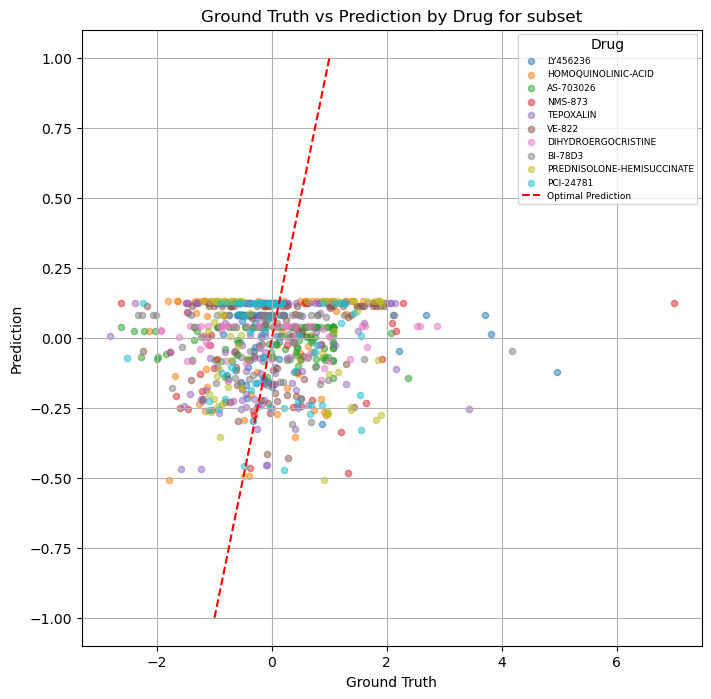

In [25]:
plt.figure(figsize=(8, 8))

# Get unique drugs from the DataFrame
unique_drugs = subset_results_val["drugs"].unique()

# Define colors for each drug
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_drugs)))

# Plot data points for each drug separately
for i, drug in enumerate(unique_drugs):
    data = subset_results_val[subset_results_val["drugs"] == drug]
    plt.scatter(data["ground_truth"], data["prediction"], color=colors[i], label=drug, alpha=0.5, s=20)

# Get min and max values of 'ground_truth' and 'prediction'
min_val = min(subset_results_val["ground_truth"].min(), subset_results_val["prediction"].min())
max_val = max(subset_results_val["ground_truth"].max(), subset_results_val["prediction"].max())

# Draw red diagonal line
plt.plot([-1, 1], [-1, 1], color="red", linestyle="--", label="Optimal Prediction")

plt.title("Ground Truth vs Prediction by Drug for subset")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.legend(title="Drug", fontsize=6.5)
plt.grid(True)
plt.show()

/Users/niklaskiermeyer/anaconda3/envs/DruxAI/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/niklaskiermeyer/anaconda3/envs/DruxAI/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


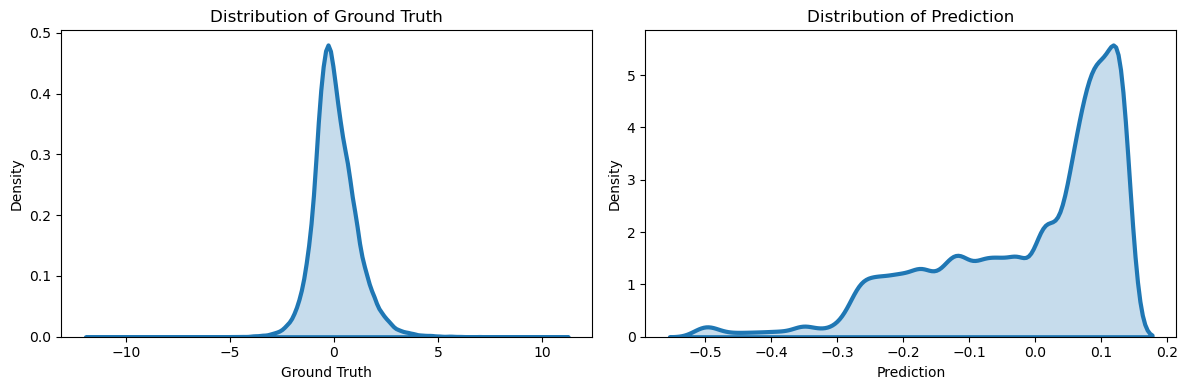

In [15]:
# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the distribution of 'ground_truth' on the first subplot
sns.kdeplot(df["ground_truth"], fill=True, linewidth=3, ax=axs[0])
axs[0].set_title("Distribution of Ground Truth")
axs[0].set_xlabel("Ground Truth")
axs[0].set_ylabel("Density")

# Plot the distribution of 'prediction' on the second subplot
sns.kdeplot(df["prediction"], fill=True, linewidth=3, ax=axs[1])
axs[1].set_title("Distribution of Prediction")
axs[1].set_xlabel("Prediction")
axs[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# Dataloading Testing that it works properly

In [16]:
# Check if dataloading works properly
epoch = 0
batch_ids = {}
while epoch < 2:
    ids = []
    for X, y, id in train_loader:
        drug, molecular = X["drug_encoding"].to(torch.device("mps")), X["gene_expression"].to(torch.device("mps"))
        outcome = y.to(torch.device("mps"))
        ids.extend(id.tolist())
    batch_ids[epoch] = ids
    epoch += 1

In [17]:
set_1 = batch_ids[0]

In [18]:
set_2 = batch_ids[1]

In [19]:
print(len(set_1), len(set_2))

389066 389066


In [20]:
print(np.unique(set_1).shape, np.unique(set_2).shape)

(389066,) (389066,)


In [21]:
print(len(set(set_1).intersection(set(set_2))))

389066


In [22]:
# Check if data loading works correctly

epoch = 0
batch_ids_val = {}
ids = []
for X, y, id in val_loader:
    drug, molecular = X["drug_encoding"].to(torch.device("mps")), X["gene_expression"].to(torch.device("mps"))
    outcome = y.to(torch.device("mps"))
    ids.extend(id.tolist())
batch_ids_val[epoch] = ids